## Mass Mobilization Research Notebook

In [2]:
#%pip install numpy pandas pandas_gbq matplotlib networkx pytrends
import numpy as np
import pandas as pd
import pandas_gbq 
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from pytrends.request import TrendReq
import os

### GDelt

In [4]:
query = """
    SELECT * FROM `gdelt-bq.full.events` WHERE EventBaseCode = "014" LIMIT 10;
"""

event_df = pandas_gbq.read_gbq(query, project_id="gdelt-d-379201")
event_df


Downloading:   0%|                                                                                                    |
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,1104337102,20230524,202305,2023,2023.3945,EDU,SCHOOL,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230524,https://wncy.com/2023/05/23/decision-for-green...
1,1104342457,20220524,202205,2022,2022.3945,COP,POLICE,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230524,https://www.standard.net.au/story/8207233/fire...
2,1104342633,20230524,202305,2023,2023.3945,None,None,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230524,https://www.standard.net.au/story/8207233/fire...
3,1104343720,20230524,202305,2023,2023.3945,JUD,PROSECUTOR,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230524,https://mynewsla.com/crime/2023/05/23/jury-beg...
4,1104343809,20230524,202305,2023,2023.3945,LEG,PARLIAMENT,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230524,https://thenewdaily.com.au/news/politics/austr...
5,1104345668,20230524,202305,2023,2023.3945,BUS,COMPANIES,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230524,http://www.econotimes.com/McDonalds-Under-Pres...
6,1104349315,20230524,202305,2023,2023.3945,POL,POLE,POL,None,None,...,None,0,None,None,None,NaN,NaN,None,20230524,https://www.wltribune.com/news/williams-lake-f...
7,1104352921,20220524,202205,2022,2022.3945,CVL,SCIENTIST,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230524,https://www.telegraphindia.com/feeds/world/cha...
8,1104353364,20230524,202305,2023,2023.3945,COP,POLICE,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230524,https://www.theage.com.au/national/nsw/lawyers...
9,1104355597,20230524,202305,2023,2023.3945,EDU,STUDENT,None,None,None,...,None,0,None,None,None,NaN,NaN,None,20230524,https://home.nzcity.co.nz/news/article.aspx?id...


### Google Trends

In [5]:
def load_keywords(kw_list):
    trends = TrendReq(hl="en-US", tz=360)
    trends.build_payload(kw_list, timeframe='today 5-y')
    kw_trend_df = trends.interest_over_time()
    
    return kw_trend_df
    
def add_keywords(new_kw_list, kw_trend_df):
    new_kw_trend_df = load_keywords(new_kw_list)
    
    for col in new_kw_trend_df.columns:
        kw_trend_df[col] = new_kw_trend_df[col]
    
    return kw_trend_df

KEYWORDS = ["blm", "defund", "abolish", "george floyd", "police", "prison", "protest", "justice", "trump", "all lives matter", "blm", "defund", "abolish", "police"]

### Load Keywords in Chunks

In [6]:
n = 4
chunks = len(KEYWORDS) // n
kw_trend_df = pd.DataFrame()

for i in range(chunks):
    kw_chunk = KEYWORDS[(i * n):((i + 1) * n)]
    kw_trend_df = add_keywords(kw_chunk, kw_trend_df)

Downloading:  31%|███████████████████████████████▍                                                                    |

<Axes: xlabel='date'>

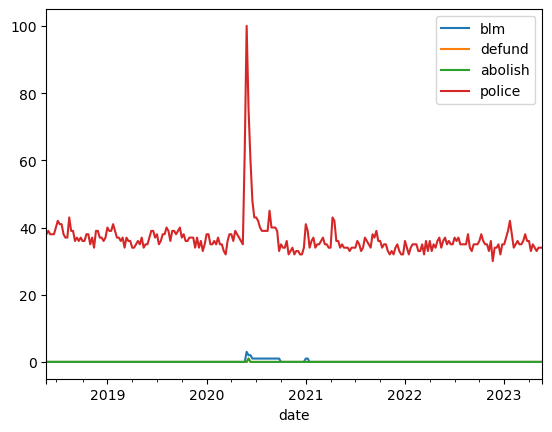

In [7]:
kw_trend_df.plot(y=["blm", "defund", "abolish", "police"], use_index=True)

#### Plotting as a Network

In [8]:
SIGNIFICANCE_THRESHOLD = 0.3

def generate_correlation_graph(trend_df, autocor=False, threshold=SIGNIFICANCE_THRESHOLD):
    kw_list = list(trend_df.columns)
    kw_list.remove("isPartial")

    kws = len(kw_list)
    correlations = np.zeros((kws, kws))
    kw_net = nx.Graph()
    
    for i in range(kws):
        kw_net.add_node(i, label=kw_list[i])
        
        for j in range(kws):
                if autocor or i != j:
                    corr = kw_trend_df[kw_list[i]].corr(kw_trend_df[kw_list[j]])
                    
                    if np.isnan(corr):
                        print(kw_list[i], kw_list[j])
                    
                    if corr != 0 and not np.isnan(corr):
                        kw_net.add_edge(i, j, corr=corr, weight=np.abs(corr))
        
    return kw_net

DEFAULT_WIDTH_FN = lambda edge: 3 * edge["corr"] ** 2

def choose_color(edge):
    if edge["corr"] > 0:
        return "lightgreen"
    else:
        return "red"

def draw(graph, layout=nx.spring_layout, width_fn=DEFAULT_WIDTH_FN):
    pos = layout(graph)
    edges = graph.edges()
    weights = [width_fn(graph[i][j]) for i,j in edges]
    edge_colors = [choose_color(graph[i][j]) for i,j in edges]
    labels = nx.get_node_attributes(graph, "label")

    nx.draw_networkx_labels(kw_net, pos, labels=labels)
    nx.draw(
        graph,
        pos,
        width=list(weights),
        node_color="lightgrey",
        edge_color=edge_colors
    )

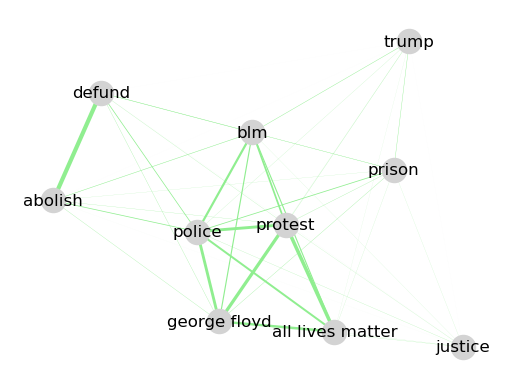

In [9]:
kw_net = generate_correlation_graph(kw_trend_df, threshold=0)
draw(kw_net, layout=nx.spring_layout)

### C-SPAN

#### Data Aggregation

In [13]:
FIRST_CONGRESS = 97
LAST_CONGRESS = 114
congresses = range(FIRST_CONGRESS, LAST_CONGRESS + 1)

def full_speeches_exist():
    for congress in congresses:
        if not os.path.isfile(f"data/full/full_{get_num(congress)}.csv"):
            return False
    return True

def get_num(congress):
    if congress < 100:
        return "0" + str(congress)
    else:
        return str(congress)

def get_full_speeches():
    for congress in congresses:
        num = get_num(congress)

        descsDf = pd.read_csv(f"data/descs/descr_{num}.txt", sep="|", encoding = 'unicode_escape', on_bad_lines='skip')
        descsDf["speech_id"] = descsDf["speech_id"].astype("string")

        speechesDf = pd.read_csv(f"data/speeches/speeches_{num}.txt", sep="|", encoding = 'unicode_escape', on_bad_lines='skip')
        speechesDf["speech_id"] = speechesDf["speech_id"].astype("string")

        speakersDf = pd.read_csv(f"data/speakers/{num}_SpeakerMap.txt", sep="|", encoding = 'unicode_escape', on_bad_lines='skip')
        speakersDf["speech_id"] = speechesDf["speech_id"].astype("string")

        descsDf = descsDf.merge(speechesDf, on="speech_id", how="outer")
        descsDf = descsDf.merge(speakersDf, on="speech_id", how="outer")

        descsDf.to_csv(f"data/full/full_{num}.csv")

if not full_speeches_exist():
    get_full_speeches()

#### Converting C-SPAN to C-TRENDS

In [22]:
num = get_num(FIRST_CONGRESS)

descs = pd.read_csv(f"data/descs/descr_{num}.txt", sep="|", encoding = 'unicode_escape', on_bad_lines='skip')
full_speech = pd.read_csv(f"data/full/full_{num}.csv")

C:\Users\isaac\AppData\Local\Temp\ipykernel_13624\3891703997.py:4: DtypeWarning: Columns (1,17,18,19,20,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  full_speech = pd.read_csv(f"data/full/full_{num}.csv")


In [49]:
def to_datetime(col):
    date = col.astype("str").str
    return pd.to_datetime(date[:4] + "/" + date[4:6] + "/" + date[6:])

def get_ctrends(phrases=[], disag=[]):
    ctrends = pd.DataFrame()

    for congress in congresses:
        num = get_num(congress)

        full_speech = pd.read_csv(f"data/full/full_{num}.csv")
        full_speech = full_speech[[*disag, "speech", "date"]]
        
        for phrase in phrases:
            full_speech[f"count_{phrase}"] = full_speech["speech"].str.count(phrase)
        
        ctrends_speech = full_speech.groupby(["date", *disag]).sum(numeric_only=True).reset_index()
        ctrends_speech = ctrends_speech.rename({f"count_{phrase}": phrase for phrase in phrases})
        ctrends_speech = ctrends_speech[[*phrases, *disag, "date"]]
        ctrends = ctrends.merge(
            ctrends_speech,
            on=["date", *disag],
            how="cross"
        )
    
    ctrends["date"] = to_datetime(ctrends["date"])
    
    return ctrends

ctrends = get_ctrends(phrases=KEYWORDS, disag=["party"])

C:\Users\isaac\AppData\Local\Temp\ipykernel_13624\2871966022.py:11: DtypeWarning: Columns (1,17,18,19,20,21,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  full_speech = pd.read_csv(f"data/full/full_{num}.csv")


KeyError: "['blm', 'defund', 'abolish', 'george floyd', 'police', 'prison', 'protest', 'justice', 'trump', 'all lives matter'] not in index"